### Final model - AdaBoost with RidgeRegression

In [246]:
import importlib
import helper_functions
import pandas as pd
importlib.reload(helper_functions)
from helper_functions import *
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV     

In [247]:
def create_sellingage(df):
    new_df = df.copy()
    new_df['SellingAge'] = new_df['YrSold'] - new_df['YearRemodAdd']
    return new_df

In [248]:
def combined_livingspace(df):
    new_df = df.copy()
    new_df['TotalSF'] = new_df['TotalBsmtSF'] + new_df['GrLivArea']
    return new_df

In [249]:
from scipy.special import boxcox1p

def normalize_skewed_features(df):
    new_df = df.copy()
    numerical_features = new_df.select_dtypes(exclude=['object'])
    skewed_feats = numerical_features.apply(lambda x: skew(x, nan_policy='omit')).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        new_df[feat] = boxcox1p(new_df[feat], lam)
    return new_df

In [250]:
# Defining pipeline as in other examples
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('normalize_skewed_features', DFTransform(lambda X: normalize_skewed_features(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X))),
    ('create_sellingage', DFTransform(lambda X: create_sellingage(X))),
    ('combined_livingspace', DFTransform(lambda X: combined_livingspace(X)))
    ])

In [251]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

In [253]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, Pipeline(steps=[
    ('ada_boost', AdaBoostRegressor(base_estimator=Ridge(alpha=10, fit_intercept=False,
                                                         normalize=False, random_state=42, solver='cholesky'),
         learning_rate=0.001, loss='linear', n_estimators=50,
         random_state=42))]), size_test=.4, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.938281974927
RMSE (log): 0.09753263417119416
Create predictions...(test)
Fitting the pipeline to all the data...
Score: 0.93318938


Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 178224.37
Difference in means is: -2696.82918753


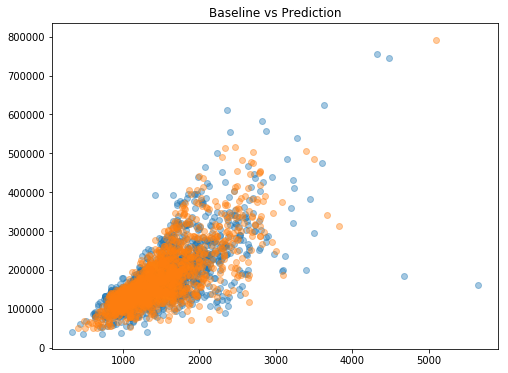

In [235]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [236]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180821122405.csv


Kaggle score: 0.12160